Evaluating gauge data

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from osgeo import ogr, gdal
import os
import geopandas
import affine
import datetime

In [7]:
df= pd.read_excel('./rainguageHarris/Harvey_RainGauge.xlsx')
df.set_index('Time', inplace= True)
df.index= df.index.tz_localize('US/Central')
df.index= df.index.tz_convert('UTC')

In [8]:
shp= geopandas.read_file('./rainguageHarris/Rain_gauges.shp')
shp['Site_ID']= shp['Site_ID'].astype(int)
# shp.set_index('Site_ID', inplace= True)

Take 5 samples that are clustered using nearest neighborhood

In [25]:
sample= df.loc[:,[250,1440,2170,2280,1130]]

In [26]:
sample.head()

,250,1440,2170,2280,1130
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0


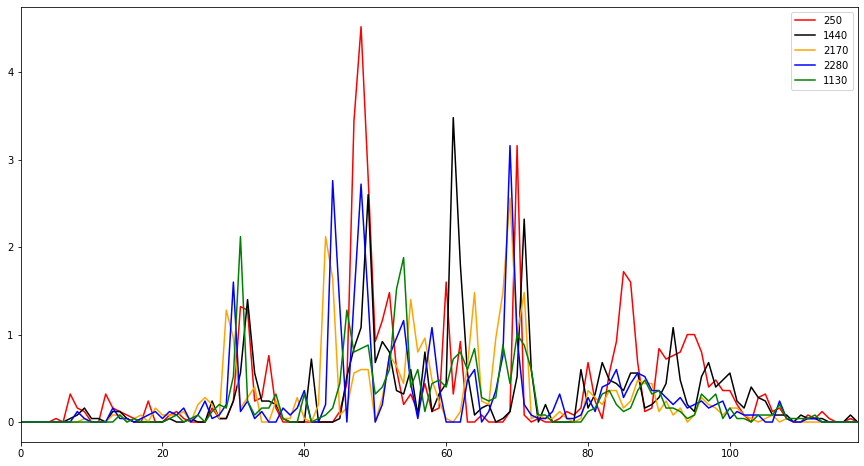

In [27]:
sample.plot(figsize=(15,8),color=['red','black','orange','blue','green'])

In [30]:
sample.corr()

,250,1440,2170,2280,1130
250,1.000000,0.452048,0.119088,0.441115,0.409795
1440,0.452048,1.000000,0.135159,0.154224,0.425908
2170,0.119088,0.135159,1.000000,0.638527,0.362686
2280,0.441115,0.154224,0.638527,1.000000,0.403415
1130,0.409795,0.425908,0.362686,0.403415,1.000000


Animation of gauge-only NCEP product

In [9]:
import re
import datetime

def retrieve_pixel_value(geo_coord, data_source):
    """Return floating-point value that corresponds to given point."""
    x, y = geo_coord[0], geo_coord[1]
    forward_transform =  \
        affine.Affine.from_gdal(*data_source.GetGeoTransform())
    reverse_transform = ~forward_transform
    px, py = reverse_transform * (x, y)
    px, py = int(px + 0.5), int(py + 0.5)
    pixel_coord = px, py

    data_array = np.array(data_source.GetRasterBand(1).ReadAsArray())
    return data_array[pixel_coord[0]][pixel_coord[1]]

gauge_pth= './rainfall_analysis/gauge4km'
geo_coors= [{'ID': int(shp.loc[n,'Site_ID']),
             'coor':(shp.loc[n,'Longitude'],shp.loc[n,'Latitude'])} for n in range(len(shp))]

def date_pattern(name):
    date_parttern= r'(2017[0-1][0-9][0-3][0-9][0-2][0-9])'
    date= re.search(date_parttern, name).group()[:8]
    time= re.search(date_parttern, name).group()[8:]
    
    return datetime.datetime.strptime(date+time, '%Y%m%d%H')

df_tif= pd.DataFrame(index= df.index, columns=[geo_coors[i]['ID'] for i in range(len(geo_coors))])
df_tif.index= df_tif.index.tz_convert('UTC')

for each in sorted(os.listdir(gauge_pth)):
    if each.endswith('.tif'):
        time= pd.Timestamp(date_pattern(each))
        time= time.tz_localize('UTC')
        gd= gdal.Open(os.path.join(gauge_pth,each))
        for point in geo_coors:
            z= retrieve_pixel_value(point['coor'], gd)
            df_tif.loc[time,point['ID']]= z
    
    

In [10]:
from scipy.stats import pearsonr
start, end= df.index[0], df.index[-1]
df_tif= df_tif[start: end]

def cor(x,y):
    mask= (~np.isnan(x)*~np.isnan(y))
    x= x[mask]
    y= y[mask]
    if len(x)<2 or len(y)<2:
        return np.nan
    else:
        return pearsonr(x,y)[0]

In [11]:
df_tif= df_tif.loc[:,df.columns]
df_coor= pd.DataFrame(index= [0], columns=df_tif.columns)
for col in df_tif.columns:
    df_coor[col]= cor(df_tif.loc[:,col].values.astype(float), df.loc[:,col].values.astype(float))

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [14]:
print(len(shp))
print(len(df_coor.columns))

104
148


In [19]:
for col in df_coor:
    if not pd.isnull(df_coor[col]).any():
        shp.loc[col, 'r']= df_coor[col][0]

In [21]:
shp.to_csv('cc.csv')

In [15]:
shp.Site_ID= shp.Site_ID.astype(int)
shp.set_index('Site_ID',inplace=True)


In [17]:
shp['r']= 0

In [12]:
mask= np.isnan(df_coor.values)
df_coor.values[~mask].mean()

0.20736544720627773

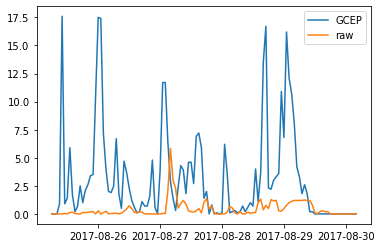

In [184]:
plt.figure()
plt.plot(df_tif.index,df_tif[105], label='GCEP')
plt.plot(df.index, df[105], label='raw')
plt.legend()

## Variogram for radar and satellite

In [214]:
#df= df.dropna(axis=1).T
# df= df.drop('Unnamed: 0', axis=0) # drop first unnamed row

ValueError: Lengths must match to compare

In [272]:
df=df.T

In [274]:
common= set(shp.index) & set(df.index)

In [277]:
for col in common:
    df.loc[col, 'Lat']= shp.loc[col,'Latitude']
    df.loc[col, 'Lon']= shp.loc[col,'Longitude']

In [268]:
df['Lat']= 0
df['Lon']= 0

Int64Index([ 100,  120,  180,  310,  340,  380,  420,  460,  470,  480,  540,
             560,  580,  590,  720,  750,  760,  790,  830,  840,  920, 1050,
            1070, 1120, 1140, 1160, 1180, 1185, 1220, 1320, 1540, 1620, 1630,
            1640, 1660, 1670, 1680, 1740, 2010, 2025, 2030, 2110, 2120, 2160,
            2210, 2240, 2270, 2290],
           dtype='int64')

In [279]:
col= []
for i in range(len(df)):
    if not pd.isnull(df.iloc[i, -1]): col.append(df.index[i])

In [280]:
df= df.loc[col,:]

In [281]:
df.head()

Time,2017-08-25 06:00:00+00:00,2017-08-25 07:00:00+00:00,2017-08-25 08:00:00+00:00,2017-08-25 09:00:00+00:00,2017-08-25 10:00:00+00:00,2017-08-25 11:00:00+00:00,2017-08-25 12:00:00+00:00,2017-08-25 13:00:00+00:00,2017-08-25 14:00:00+00:00,2017-08-25 15:00:00+00:00,...,2017-08-29 21:00:00+00:00,2017-08-29 22:00:00+00:00,2017-08-29 23:00:00+00:00,2017-08-30 00:00:00+00:00,2017-08-30 01:00:00+00:00,2017-08-30 02:00:00+00:00,2017-08-30 03:00:00+00:00,2017-08-30 04:00:00+00:00,Lat,Lon
105,0.0,0.0,0.0,0.0,0.00,0.04,0.00,0.12,0.16,0.04,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,29.543475,-95.217353
110,0.0,0.0,0.0,0.0,0.00,0.00,0.04,0.12,0.12,0.04,...,0.12,0.12,0.12,0.00,0.0,0.0,0.0,0.00,29.507960,-95.117410
115,0.0,0.0,0.0,0.0,0.08,0.08,0.00,0.24,0.12,0.04,...,0.04,0.08,0.04,0.00,0.0,0.0,0.0,0.00,29.513234,-95.222531
125,0.0,0.0,0.0,0.0,0.28,0.36,0.00,0.20,0.12,0.04,...,0.04,0.04,0.04,0.00,0.0,0.0,0.0,0.04,29.495189,-95.223522
130,0.0,0.0,0.0,0.0,0.12,0.00,0.00,0.12,0.16,0.04,...,0.04,0.12,0.04,0.04,0.0,0.0,0.0,0.00,29.497498,-95.159806


In [282]:
df.to_csv('gauge_data.csv')

In [5]:
from skgstat import Variogram


ModuleNotFoundError: No module named 'skgstat'

## evaluating radar data quality

In [1]:
import gzip

In [2]:
pth= 'cleaned/mrms2017/RadarQualityIndex_00.00_20170825-000400.grib2.gz'
with gzip.open(pth, 'rb') as f:
    file_content = f.read()

In [3]:
file_content

b'GRIB\x00\x00\xd1\x02\x00\x00\x00\x00\x00\x05\xd3\xda\x00\x00\x00\x15\x01\x00\xa1\x00\x00\xff\x01\x03\x07\xe1\x08\x19\x00\x04\x00\x02\x07\x00\x00\x00H\x03\x00\x01u\xd7 \x00\x00\x00\x00\x02\x01\x00a(\xee\x01\x00aR\xb0\x01\x00`\xff\'\x00\x00\x1bX\x00\x00\r\xac\x00\x00\x00\x01\x00\x0fB@\x03G(8\r\xb5\x99\x080\x011@\x89\x11\xe1\x8fv\x00\x00\'\x10\x00\x00\'\x10\x00\x00\x00\x00"\x04\x00\x00\x00\x00\x08\x00\x08\x00a\x00\x00\x00\x00\x00\x00\x00\x00f\x00\x00\x00\x00\x00\xff\x01\x00\x00\x00\x00\x00\x00\x00\x15\x05\x01u\xd7 \x00)\xc1\xf0\x00\x00\x00\x00\x00\x01\x08\x00\x00\x00\x00\x06\x06\xff\x00\x05\xd3,\x07\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x1bX\x00\x00\r\xac\x08\x00\x00\x00\x006\xfd\x16\xa8\x00\x00 \x00IDATx\x9c\xec\xdd\xdb\xb6\xa3\xba\x96\xad\xeb*p\xcc\xdb]\xf6\x0b\xcc,\xf3\xfd\x1f*3\xd7\x13\xec\xdb5\xc2R\xdb\x17\x12 @\x808\xf8\xfc\x7f%\xe7\x08\x1b\x04\xc6\xd8\xbdG\x16\xd5hMNx\x0b\xff\x9enp\x8bC\x8b{\xe6\x1b\xdd\xd6\x80\xe2\x89\xca/\xbb|1\xf5#\x96\x85\xfcIs\xe2DK\xccI\x92IV\xd8Y~\xc1